In [1]:
%autoreload 2

from VMTest import *
import qgrid

In [2]:
def removeAuthors(df):
    skipAuthors = loadSQL('skipAuthors','reference')['0']
    subset = df[~df['author'].isin(skipAuthors)].copy()
    
    return subset

def getAuthorCounts(char, skipAuthors=False):
    df = loadSQL(char, database_name, index_col='index')
    counts = df.groupby('subreddit')['author'].count()
    counts.name = char
    
    return counts

def getTotal(countsList):
    totals = pd.concat(countsList, axis=1)
    totals.index.name = 'subreddit'
    totals['TOTAL'] = totals.sum(axis=1)
    totals.sort_values('TOTAL', ascending=False, inplace=True)
    
    return totals

def getCommentTotals():
    database_name = 'allEdges'
    completed = checkCompleted(database_name)
    engine = get_engine(database_name)

    dfs = []
    for char in completed:
        query = """
        SELECT author, subreddit, weight FROM '{0}'
        WHERE (author in
                    (SELECT author FROM '{0}'
                    WHERE (subreddit == '{1}') and
                            (weight > 2)))
            and (weight > 2)
        """.format(char, subreddit)

        data = pd.read_sql_query(query, engine)
        dfs.append(data)
    df = pd.concat(dfs)
        
    return df

def getSubredditNetwork(subreddit):
    database_name = 'allEdges'
    completed = checkCompleted(database_name)
    engine = get_engine(database_name)

    dfs = []
    for char in completed:
        query = """
        SELECT author, subreddit, weight FROM '{0}'
        WHERE (author in
                    (SELECT author FROM '{0}'
                    WHERE (subreddit == '{1}') and
                            (weight > 2)))
            and (weight > 2)
        """.format(char, subreddit)

        data = pd.read_sql_query(query, engine)
        dfs.append(data)
    df = pd.concat(dfs)
        
    return df

def getCommentCounts(char, skipAuthors=False):
    df = loadSQL(char, database_name, index_col='index')
    if skipAuthors:
        df = removeAuthors(df)
        df = df[df['weight']>2]
    counts = df.groupby('subreddit')['weight'].sum()
    counts.name = char
    
    return counts

def getSubredditCommentCounts(subreddit, skipAuthors=False):
    df = getSubredditNetwork(subreddit)
    if skipAuthors:
        df = removeAuthors(df)
    counts = df.groupby('subreddit')['weight'].sum().sort_values(ascending=False)
    
    return counts

def scatter(df, x, y):
    df.plot(x, y, kind='scatter');
    
def getRankComparison(rank, totalRank):
    m = pd.merge(rank, totalRank, on='subreddit', suffixes=('','Total'), how='outer').fillna(0)
    m['rankDiff'] = (m['rankTotal']+1)-m['rank'] # +1 discounts subreddit in first position
    m['ratio'] = (m['weight'])/m['weightTotal'] # +1 for missing subreddits
    
    return m

In [ ]:
database_name = 'allEdges'
completed = checkCompleted(database_name)

commentCounts = []

for char in completed:
    counts = getCommentCounts(char, skipAuthors=True)
    commentCounts.append(counts)
    
totals = getTotal(commentCounts)
totalRank= totals['TOTAL'].reset_index().reset_index()
cols = ['rank','subreddit','weight']
totalRank.columns = cols

In [ ]:
subreddit = 'changemyview'
df = getSubredditNetwork(subreddit)
subset = removeAuthors(df)

In [ ]:
counts = subset.groupby('subreddit')['weight'].sum().sort_values(ascending=False)
rank = counts.reset_index().reset_index()

cols = ['rank','subreddit','weight']
rank.columns = cols
cmv = getRankComparison(rank, totalRank)
cmv = cmv[['subreddit','weight','weightTotal','ratio','rank','rankTotal','rankDiff']]

In [ ]:
node_stats = project(subset)
node_stats.sort_values('degree', ascending=False, inplace=True)

In [ ]:
database_name = 'allEdges'
completed = checkCompleted(database_name)
engine = get_engine(database_name)

dfs = []
for char in completed:
    query = """
    SELECT author, subreddit, weight FROM '{0}'
    WHERE (weight > 2)
    """.format(char)

    data = pd.read_sql_query(query, engine)
    subset = removeAuthors(data)
    dfs.append(subset)
allEdges = pd.concat(dfs)

full_node_stats = project(allEdges)
full_node_stats.sort_values('degree', ascending=False, inplace=True)

# Entropy

A measure of dispersion that considers the number of diverse objects as well as the relative weights

In [159]:
def getEntropyDf(df, groupby):
    weights = df.groupby(groupby)['weight'].apply(tuple)
    w = pd.DataFrame({'weights':weights})
    w['subreddits'] = subset.groupby('author')['subreddit'].apply(tuple)
    w['entropy'] = w['weights'].apply(lambda x: sp.stats.entropy(x))
    w['num_x'] = w['weights'].apply(lambda x: len(x))
    w['num_comments'] = w['weights'].apply(lambda x: np.sum(x))
    
    w['log_x'] = np.log(w['num_x'])
    w['log_comments'] = np.log(w['num_comments'])
    
    return w

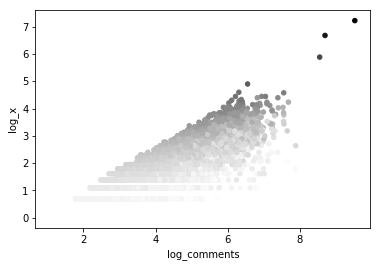

In [132]:
author_entropy = getEntropyDf(subset, 'author')
author_entropy.plot('log_comments','log_x',kind='scatter',color=author_entropy['entropy']);

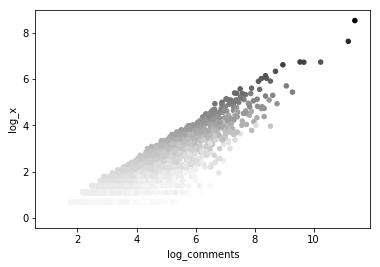

In [133]:
subreddit_entropy = getEntropyDf(subset, 'subreddit')
subreddit_entropy.plot('log_comments','log_x',kind='scatter',color=subreddit_entropy['entropy']);

Entropy is affected by the number of subreddits more than the total number of comments, so it is good to suggest the level of dispersion, whilst still considering the number of comments

In [146]:
counts = subset.groupby('subreddit')['weight'].sum().sort_values(ascending=False)
rank = counts.reset_index().reset_index()

cols = ['rank','subreddit','weight']
rank.columns = cols
rank = rank.set_index('subreddit')

In [147]:
rank['entropy'] = subreddit_entropy['entropy']

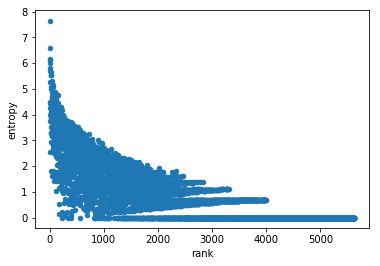

In [151]:
scatter(rank, 'rank','entropy')

## Author Entropy

In [226]:
database_name = 'allEdges'
completed = checkCompleted(database_name)
engine = get_engine(database_name)


subreddit = 'changemyview'
char = 'a'
query = """
SELECT author, subreddit, weight FROM '{0}'
WHERE (weight > 2) and (author == '{1}')
""".format(char, subreddit)

df = pd.read_sql_query(query, engine)
data = removeAuthors(df)

In [ ]:
aAuthorEntropy = getEntropyDf(data, 'author')

aCMV = aAuthorEntropy[aAuthorEntropy['subreddits'].apply(lambda x: True if "changemyview" in x else False)]
aTD = aAuthorEntropy[aAuthorEntropy['subreddits'].apply(lambda x: True if "The_Donald" in x else False)]

In [210]:
print('the median entropy for all authors is {:,.2f}'.format(aAuthorEntropy.entropy.median()))
print('the median entropy for CMV authors is {:,.2f}'.format(aCMV.entropy.median()))
print('the median entropy for TD authors is {:,.2f}'.format(aTD.entropy.median()))

the median entropy for all authors is 0.00
the median entropy for CMV authors is 1.50
the median entropy for TD authors is 0.83


In [228]:
query = """
SELECT author, subreddit, weight FROM '{0}'
WHERE (weight > 2)
""".format(char, subreddit)

df = pd.read_sql_query(query, engine)
total_data = removeAuthors(df)

In [303]:
sample = list(total_data.subreddit.sample(100)) + ['changemyview', 'The_Donald']
d = {}
for sub in sample:
    entropy_subset = aAuthorEntropy[aAuthorEntropy['subreddits'].apply(lambda x: True if sub in x else False)]
    median_entropy = entropy_subset.entropy.median()
    d[sub] = median_entropy

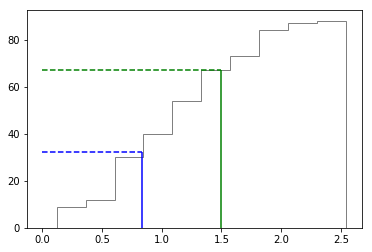

In [304]:
import matplotlib.pyplot as plt
%matplotlib inline

s = pd.Series(d).sort_values()

x = s[['changemyview','The_Donald']]
xmin = 0

y = [s.index.get_loc('changemyview'),s.index.get_loc('The_Donald')]
ymin = 0

colors = ['green','blue']

fig, ax = plt.subplots()
ax.hist(s, cumulative=True, color='grey', histtype='step', align='right')
ax.vlines(x=x, ymin=ymin, ymax=y, colors=colors);
ax.hlines(y=y, xmin=xmin, xmax=x, colors=colors, linestyles='dashed');

In [3]:
import scipy as sp

sp.stats.entropy?

Object `sp.stats.entropy` not found.


In [305]:
total_data.subreddit.unique().shape

(16287,)

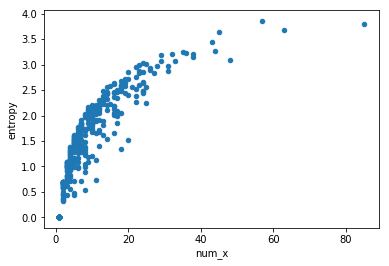

In [211]:
scatter(aCMV, 'num_x','entropy')

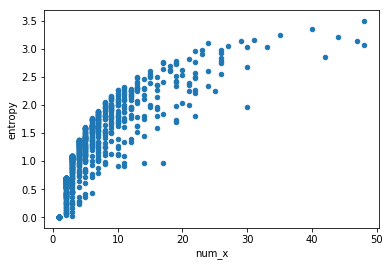

In [212]:
scatter(aTD, 'num_x','entropy')

## Subreddit Entropy

In [213]:
subreddit_entropy.head()

,weights,subreddits,entropy,num_x,num_comments,log_x,log_comments
subreddit,,,,,,,
0xProject,"(4,)",NaN,0.00000,1,4,0.000000,1.386294
100movies365days,"(3,)",NaN,0.00000,1,3,0.000000,1.098612
1200isplenty,"(5, 3, 12, 3, 3, 3, 6, 19, 3)",NaN,1.91954,9,57,2.197225,4.043051
13451452251849519,"(3,)",NaN,0.00000,1,3,0.000000,1.098612
13ReasonsWhy,"(19,)",NaN,0.00000,1,19,0.000000,2.944439


In [215]:
sCMV = subreddit_entropy

In [216]:
sCMV.entropy.describe()

count    5626.000000
mean        0.782052
std         1.017915
min         0.000000
25%         0.000000
50%         0.519580
75%         1.268863
max         7.652037
Name: entropy, dtype: float64

In [217]:
sEntropy = getEntropyDf(data, 'subreddit')
#sEntropy['authors'] = data.groupby('subreddit')['author'].apply(tuple)

In [218]:
sEntropy.head()

,weights,subreddits,entropy,num_x,num_comments,log_x,log_comments
subreddit,,,,,,,
0xProject,"(3, 4, 5, 6, 6, 7, 10)",NaN,1.883413,7,41,1.945910,3.713572
0xbitcoin,"(6, 7)",NaN,0.690186,2,13,0.693147,2.564949
100thieves,"(30, 3, 3, 3, 5, 6)",NaN,1.297599,6,50,1.791759,3.912023
1022,"(4, 4, 4, 5, 9)",NaN,1.548183,5,26,1.609438,3.258097
1200isjerky,"(40, 3, 3, 4, 4, 5)",NaN,1.140514,6,59,1.791759,4.077537


In [220]:
sEntropy.entropy.describe()

count    16482.000000
mean         1.139672
std          1.281558
min          0.000000
25%          0.000000
50%          0.693147
75%          1.891313
max          8.701562
Name: entropy, dtype: float64

In [221]:
m = pd.merge(sEntropy, sCMV, right_index=True, left_index=True, how='inner',suffixes=['_total','_CMV'])
m.head()

,weights_total,subreddits_total,entropy_total,num_x_total,num_comments_total,log_x_total,log_comments_total,weights_CMV,subreddits_CMV,entropy_CMV,num_x_CMV,num_comments_CMV,log_x_CMV,log_comments_CMV
subreddit,,,,,,,,,,,,,,
0xProject,"(3, 4, 5, 6, 6, 7, 10)",NaN,1.883413,7,41,1.945910,3.713572,"(4,)",NaN,0.00000,1,4,0.000000,1.386294
1200isplenty,"(20, 15, 14, 22, 13, 26, 23, 44, 15, 16, 53, 3...",NaN,4.496973,127,998,4.844187,6.905753,"(5, 3, 12, 3, 3, 3, 6, 19, 3)",NaN,1.91954,9,57,2.197225,4.043051
13451452251849519,"(32, 17, 3, 3, 3, 4, 8)",NaN,1.517975,7,70,1.945910,4.248495,"(3,)",NaN,0.00000,1,3,0.000000,1.098612
13ReasonsWhy,"(3, 3, 4, 4, 5)",NaN,1.590270,5,19,1.609438,2.944439,"(19,)",NaN,0.00000,1,19,0.000000,2.944439
13or30,"(3, 4, 4, 6, 11, 12)",NaN,1.655568,6,40,1.791759,3.688879,"(4,)",NaN,0.00000,1,4,0.000000,1.386294


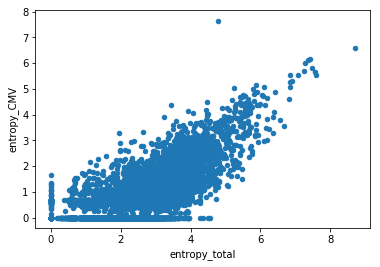

In [222]:
scatter(m, 'entropy_total','entropy_CMV')

In [224]:
m.sort_values(['entropy_total','entropy_CMV'], ascending=[True,False]).head()

,weights_total,subreddits_total,entropy_total,num_x_total,num_comments_total,log_x_total,log_comments_total,weights_CMV,subreddits_CMV,entropy_CMV,num_x_CMV,num_comments_CMV,log_x_CMV,log_comments_CMV
subreddit,,,,,,,,,,,,,,
TMBR,"(5,)",NaN,0.0,1,5,0.0,1.609438,"(12, 5, 3, 12, 3, 6)",NaN,1.639738,6,41,1.791759,3.713572
highthoughts,"(3,)",NaN,0.0,1,3,0.0,1.098612,"(3, 5, 3, 5)",NaN,1.354710,4,16,1.386294,2.772589
LessCredibleDefence,"(4,)",NaN,0.0,1,4,0.0,1.386294,"(16, 5, 10, 17)",NaN,1.296220,4,48,1.386294,3.871201
WordAvalanches,"(3,)",NaN,0.0,1,3,0.0,1.098612,"(4, 3, 9, 4)",NaN,1.287672,4,20,1.386294,2.995732
ideasforcmv,"(11,)",NaN,0.0,1,11,0.0,2.397895,"(11, 4, 3, 3)",NaN,1.210537,4,21,1.386294,3.044522


In [10]:
from VMTest import *

def saveSQL(df, table_name, database_name, **kwargs):
    engine = get_engine(database_name=database_name)
    df.to_sql(name=table_name, con=engine,  **kwargs)
    
def loadSQL(table_name, database_name, index_col='index'):
    engine = get_engine(database_name=database_name)
    df = pd.read_sql_table(table_name=table_name, con=engine, index_col=index_col)
    
    return df


ra = loadSQL('defaults','reference')
ra.head()

,defaults
index,
0,Art
1,AskReddit
2,DIY
3,Documentaries
4,EarthPorn


In [16]:
saveSQL(ra, 'defaults','allEdges', if_exists='replace')

In [15]:
ra.columns = ['subreddit']
ra.head()

,subreddit
index,
0,Art
1,AskReddit
2,DIY
3,Documentaries
4,EarthPorn
